https://www.kaggle.com/PromptCloudHQ/imdb-data/data / 
https://www.kaggle.com/tmdb/tmdb-movie-metadata/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
% matplotlib inline
import seaborn as sns
import scipy.stats as stats
import json
import re

In [2]:
from sklearn.preprocessing import normalize

# Narrative Analytics and Experimentation: The Movie Edition
***
***

### The film industry is one of many that has been adversely affected by the widespread usage of the internet.  
#### - Online streaming platforms (i.e., Netflix, Hulu, Amazon Prime) are a popular medium of movie/tv consumption as it enables consumers/viewers to be able to watch movies from the comforts of their own home. <br> <br> - Making matters worse is the rise in popularity in premium television content which require consumers to subscribe to some platform in order to watch these "premium" content (think *Mad Men*, *Game of Thrones*, *Stranger Things* ). <br> <br> - As popular as these shows are, these online platforms offer other content as well - movies and television content from other production studios - that further entice consumers to forego going to the theater in favor of watching (or doing) something else at home.  

In [3]:
# call df of boxoffice ; from the-numbers.com
bo = pd.read_csv('boxoffice.csv')

# column names cut off, renaming
bo.rename(columns={'Total Inflation':'infltn_adj', 'Average': 'ticket_price', 
                   'Tickets Sold':'tickets', 'Total Box Office':'box_office'}, inplace=True)

# drop first row that is an extension of column names
bo.dropna(axis=0, how='any', inplace=True)

# drop row for 2018, as it is incomplete and annualized
bo = bo[bo['Year']!=2018.0].reset_index(drop=True)

# reset another time to get number mapping to 'Year'
bo = bo.reset_index()
bo.rename(columns={'index':'year'}, inplace=True)

# change year from float to int
bo.Year = bo.Year.apply(lambda x: int(x))

# change type of ticket price, str to float
cols = ['box_office', 'infltn_adj']
for c in cols:
    # .replace takes out commas, [1:] takes out dollar symbol
    bo[c] = bo[c].apply(lambda x: int(x.replace(',', '')[1:]))
bo['tickets'] = bo['tickets'].apply(lambda x: int(x.replace(',', '')))
bo['ticket_price'] = bo['ticket_price'].apply(lambda x: float(x[1:]))

# flip 'year' column
bo['year'] = bo.year.sort_values(ascending=False).values
bo = bo.reindex(bo['year'])

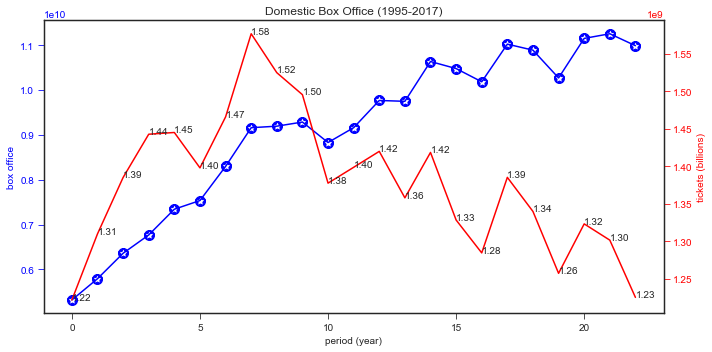

In [4]:
sns.set_style('ticks')

# copied, pasted from plt docs for study


# ('5' is number of vertices for star)
star = mpath.Path.unit_regular_star(5)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
# i think 2 separate things are being concatenated: vertices and codes... what are they?
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)



fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(bo['year'], bo['box_office'], 'b-', marker=cut_star, markersize=10)
ax1.set_title('Domestic Box Office (1995-2017)')
ax1.set_xlabel('period (year)')
ax1.set_ylabel('box office', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(bo.year, bo.tickets, 'r-')
for a,b in zip(bo['year'], bo['tickets']):
    plt.text(a, b, str("%.2f" % round((b/1000000000),2)))
    # rounding is complicated apparently; "%.2f" % round(a, 2) works in print and str(), etc
ax2.set_ylabel('tickets (billions)', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

##### There is a clear sign of decreasing ticket sales.  
#### Despite this, the box office has been still increasing, albeit at a visibly reduced rate, implying that there is another variable that is not only offsetting the decrease in ticket sales, but also causing an overall increase that we see for the box office.
-plug [rounding floats](https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points)-

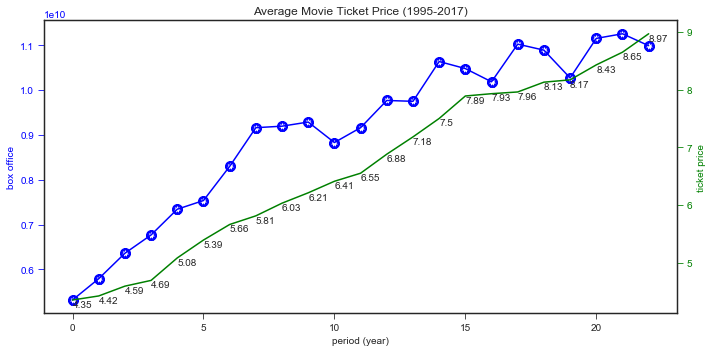

In [5]:
fig, ax1 = plt.subplots(figsize=(10,5))


# ('7' is number of vertices for star)
star = mpath.Path.unit_regular_star(7)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
# i think 2 separate things are being concatenated: vertices and codes... what are they?
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

ax1.plot(bo['year'], bo['box_office'], 'b-', marker=cut_star, markersize=10)
ax1.set(title='Average Movie Ticket Price (1995-2017)', xlabel='period (year)')
ax1.set_ylabel('box office', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(bo.year, bo.ticket_price, 'g-')
for a, b in zip(bo.year, bo.ticket_price):
    plt.text(a, b, str(b), verticalalignment='top')
ax2.set_ylabel('ticket price', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()

##### Increasing ticket prices have kept the box office steadily increasing
- *particularly in recent years* where the growth in ticket price outpaces the growth in box office.

Since the box office is essentially just the *"ticket price" times "ticket sales"*, we cannot make any assumptions with just these variables, as the **box office** is synonymous with "revenue", and **revenue is a dependent variable.**
>There are also undoubtedly external factors influencing the box office as well; the research will exclude such variables, such as:<br>
- economic factors, one-off events (natural disasters), competition across industries
- also take into account actual supply-demand relationship of this product
    - product could be inelastic

In [6]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [7]:
tmdb = load_tmdb_movies('tmdb_5000_movies.csv')

In [8]:
# just wow
def get_dv(keywords):
    '''retrieves dictionary values from list of dictionaries
    Parameters: keywords (list of dictionaries)
    '''
    return ','.join([x['name'] for x in keywords])

In [9]:
# overwriting columns with list of dictionaries as values
tmdb['production_companies'] = tmdb['production_companies'].apply(lambda x: get_dv(x))
tmdb['genres'] = tmdb['genres'].apply(lambda x: get_dv(x))
tmdb['keywords'] = tmdb['keywords'].apply(lambda x: get_dv(x))

In [10]:
# Cleaning data 

tmdb.rename(columns={'title': 'Title'}, inplace=True)

# excluding movies with 0 revenue, budget, runtime
# including only movies with english as original language (want Hollywood movies)
tmdb['studio_count'] = tmdb['production_companies'].str.len()
tmdb = tmdb[(tmdb['studio_count'] > 0) & (tmdb['revenue'] > 0) & (tmdb['budget'] > 0) & (tmdb['runtime'] > 0)
           & (tmdb['original_language'] == 'en')]


tmdb = tmdb.reset_index(drop=True)

#changing one value to include global box office
tmdb.loc[13, 'revenue'] = 260502115
tmdb.loc[283, 'revenue'] = 325338851

# adding year
tmdb['year'] = tmdb['release_date'].apply(lambda x: str(x)[:4])

# change revenue, budget, (adding column) profit to be in millions
tmdb['rev'] = tmdb.revenue.apply(lambda x: x/1000000)
tmdb['budg'] = tmdb.budget.apply(lambda x: x/1000000)
tmdb['prof'] = tmdb['rev'].subtract(tmdb['budg'])

In [11]:
# columns of interest
cols_tmdb = ['Title', 'year', 'rev', 'budg', 'prof', 'genres', 'production_companies', 'popularity', 'vote_average', 'vote_count', 'release_date']
tmdb1 = tmdb[cols_tmdb]

# Lose ~1000 rows when attempting to capture "recent" observations only
tmdb1 = tmdb1[tmdb1['year'] >= '1989']
tmdb1['year'] = tmdb1['year'].apply(lambda x: int(x))

### Determining the main drivers of the box office requires an understanding of the industry's supply-demand relationship.
Aside from the points mentioned earlier, there could be various idiosyncratic reasons as to why people are no longer going to the movies as often as in years past:
- Too many comic book movies
- Too many blockbusters
- Too many sequels
- Too much to choose from...

The last point may seem a bit ridiculous, except if you consider the [studies](https://www.nytimes.com/2010/02/27/your-money/27shortcuts.html) linking indecision with too many options. And there is clearly a theme of excess in the film industry.  

#### After the implementation of Disney's *Marvel Cinematic Universe* (MCU), every other major studio decided to try and emulate Disney's model of a "shared universe" of blockbusters
>"A shared universe or shared world is a set of creative works where more than one writer (or other artist) independently contributes a work that can stand alone but fits into the joint development of the storyline, characters, or world of the overall project. It is common in genres like science fiction." - via wikipedia 

#### There has also been a trend of either remaking, making sequels of, or just reusing old creative content.

<img src="studiofranch.jpg" alt="Drawing" style="width: 450px;"/>
- Most circles are franchises, only the circles with multiple entries are "shared universes"  <br>
***
***

###  With the repurcussions of the housing crash still sitting in everyone's mind - making it harder to justify the ever-increasing price of movie tickets and concession-stand items - consumers are becoming more selective and cost-conscious. 
#### They want more bang for their buck, and that almost always means blockbusters.


In [12]:
avg_budg = tmdb1.groupby('year')['budg'].mean()
avg_rev = tmdb1.groupby('year')['rev'].mean()

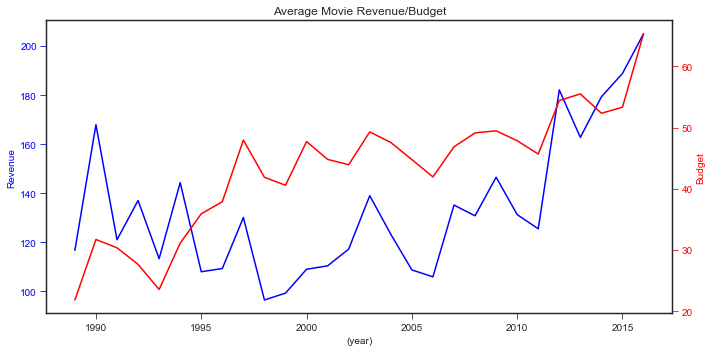

In [13]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(avg_rev.index, avg_rev, 'b-')
ax1.set(title='Average Movie Revenue/Budget', xlabel='(year)')
ax1.set_ylabel('Revenue', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(avg_rev.index, avg_budg, 'r-')
ax2.set_ylabel('Budget', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [14]:
one00 = tmdb1[tmdb1['budg'] > 100].groupby('year')['Title'].count()
one50 = tmdb1[tmdb1['budg'] > 150].groupby('year')['Title'].count()

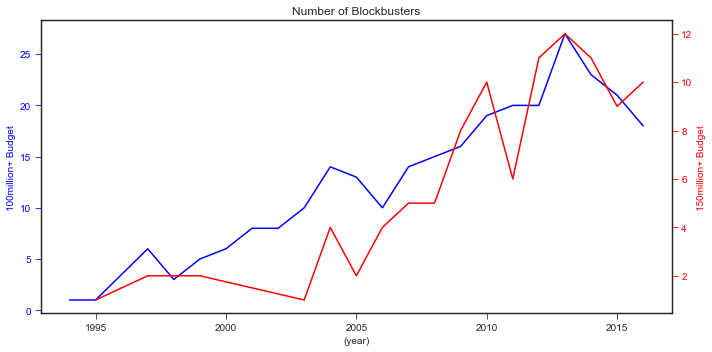

In [15]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(one00.index, one00, 'b-')
ax1.set(title='Number of Blockbusters', xlabel='(year)')
ax1.set_ylabel('100million+ Budget', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(one50.index, one50, 'r-')
ax2.set_ylabel('150million+ Budget', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


With studios producing more and more blockbusters, the benchmarks for box-office success having become blurred due to the outsized performance of Disney's Marvel films, and consumers having more options to choose from; the movie industry is in a **period of disruption and innovation** that could ultimately lead to a changing of the guard (already one of the *major 6 studios* are showing signs of an unrecoverable fall from grace, following the footsteps of MGM studios). 


### But if you were only to take a look at Disney, just producing box-office hit after hit after hit, it appears doubtful that there really is any sort of volatility or disruption in the industry.
***
***


So, what makes Disney so different?

Does Disney actually perform better than the other major studios? or is all the extra attention merely the product of Disney's brand?  
Asking these questions in a more industry-wide manner...

## What are the main factors driving the box-office success for movies? 
    
### Is it just Disney, who happened to uncover the formula to success?

#### The research will be focused around determining the variables that drive a movie's box-office performance.

***
***

### Data Exploration and Discovery 
*Start off by looking into dataset to look for potential variables with influence over box office*
- One of the more influential variables in this dataset is the **production studio(s)** of the movie, and that could very well be the answer to this research: **certain film studios simply make better movies.**

In [16]:
# seperating non-Disney Marvel movies, which have no direct relationship with Disney
f_not_dis = tmdb1[tmdb1.production_companies.str.contains('Marvel') & tmdb1.production_companies.str.contains('Fox')]
s_not_dis = tmdb1[tmdb1.production_companies.str.contains('Marvel') & tmdb1.production_companies.str.contains('Columbia')]
u_not_dis = tmdb1[tmdb1.production_companies.str.contains('Marvel') & tmdb1.production_companies.str.contains('Universal')]
pac_rim = tmdb1[tmdb1.production_companies.str.contains('Disney Double Dare')]

p_r = tmdb1.loc[pac_rim.index, 'production_companies'].str.replace('Disney Double Dare You','')
f_marv = tmdb1.loc[f_not_dis.index, 'production_companies'].str.replace('Marvel', 'marvel')
s_marv = tmdb1.loc[s_not_dis.index, 'production_companies'].str.replace('Marvel', 'marvel')
u_marv = tmdb1.loc[u_not_dis.index, 'production_companies'].str.replace('Marvel', 'marvel')

In [17]:
# contd.
tmdb1.loc[pac_rim.index, 'production_companies'] = p_r
tmdb1.loc[f_not_dis.index, 'production_companies'] = f_marv
tmdb1.loc[s_not_dis.index, 'production_companies'] = s_marv
tmdb1.loc[u_not_dis.index, 'production_companies'] = u_marv

In [18]:
fox_1 = ['Fox']
lgf_1 = ['Lions', 'Summit']
sony_1 = ['Sony', 'Columbia']
univ_1 = ['Universal', 'DreamWorks']
dis_1 = ['Disney', 'Pixar', 'Marvel']
wb_1 = ['Warner', 'New Line Cinema']
para_1 = ['Paramount']

dict_studios = {'dis':dis_1, 'univ':univ_1, 'wb':wb_1, 'fox':fox_1, 'sony':sony_1, 'para':para_1, 'lgf':lgf_1 }
list_studios = list(dict_studios.keys())

In [19]:
def studio_reg(studio):
    # okay for now, but set boundaries on regex
    temp = re.compile('|'.join(studio))
    return temp

In [20]:
# separate dataframes for each major studio (plus Lionsgate which is not a major studio but closest to it)

dis = tmdb1[tmdb1.production_companies.str.contains(studio_reg(dis_1))].reset_index()
fox = tmdb1[tmdb1.production_companies.str.contains(studio_reg(fox_1))].reset_index()
wb = tmdb1[tmdb1.production_companies.str.contains(studio_reg(wb_1))].reset_index()
univ = tmdb1[tmdb1.production_companies.str.contains(studio_reg(univ_1))].reset_index()
sony = tmdb1[tmdb1.production_companies.str.contains(studio_reg(sony_1))].reset_index()
para = tmdb1[tmdb1.production_companies.str.contains(studio_reg(para_1))].reset_index()
lgf = tmdb1[tmdb1.production_companies.str.contains(studio_reg(lgf_1))].reset_index()


In [21]:
for studio, subsids in dict_studios.items():
    tmdb1[studio] = tmdb1['production_companies'].str.contains(studio_reg(subsids)).apply(lambda x:1 if x else 0)

In [22]:
def ftr_groupby(list_feature, cols, df1=tmdb1):
    '''group by features, return sns compatible df'''
    df = pd.DataFrame()
    for studio in list_feature:
        temp = df1.groupby(studio)[cols].get_group(1)
        temp['studio'] = studio
        temp['metric'] = cols[1]
        temp.rename(columns={cols[1]:'kpi'}, inplace=True)
        df = pd.concat([df, temp])
        
    return df
# the function groups by feature and returns sns-compatible df (only one feature)
# another function when groupby multiple features? or one function do both

In [23]:
studios_rev = ftr_groupby(list_studios, ('Title', 'rev'))
studios_budg = ftr_groupby(list_studios, ('Title', 'budg'))
studios_concan = pd.concat([studios_rev, studios_budg], axis=0)

From the boxplots below, *Disney* appears to have a better track record than ***most*** of the other studios, but there are a few points worth mentioning. 
- From an **eye test**, Disney is a noticeably better studio;
- Disney's boxplots (mainly focusing on revenue) are right-skewed (mean>median); 
- some of the **other studios have many outliers** past the *right* whisker - which may eventually result in a boxplot distribution, or shape, similar to Disney's (specifically Warner Bros.).

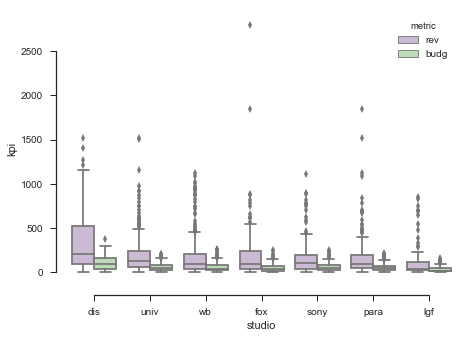

In [24]:
sns.set(style="ticks", )
ax, fig = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="studio", y='kpi', hue='metric', data=studios_concan, palette="PRGn")
sns.despine(offset=10, trim=True)


***
*Before* analyzing the studios relative to each other, validating a studio's performance will be done first in order to account for all variables and features that drive the KPIs.

By doing this, we hope to determine if there exists any "outliers" in a studio's performance and the variables/features that caused the outlier.
<br>Thereafter, we would group the studios' movies by these variables/features, which may provide more insights and accurate test results. 

As major studios usually own a few other studios that function as subsidiaries, **grouping into individual "sub-studios"** provides a simple and insightful option for our base analysis.
- This is especially true for Disney, as Disney's subsidiary studios are relatively huge as far as subsidiary studios go
- examples of A/A testing would include:
    - disney movies against pixar movies
    - non-animated movies against animated movies

In [25]:
# Disney's portfolio includes two big brands, Marvel and Pixar
# separate each studio

dis_pix = 'Pixar Animation Studios'
dis_marv = 'Marvel Studios'

dis_only = dis[dis.production_companies.apply(lambda x: dis_pix not in x and dis_marv not in x)]
marv_only = dis[dis.production_companies.apply(lambda x: dis_marv in x)]
pixar_only = dis[dis.production_companies.apply(lambda x: dis_pix in x)]

In [26]:
# check if dataframes are correct (at least partly by checking length of each df)
len(dis_only) + len(marv_only) + len(pixar_only) == len(dis)

True

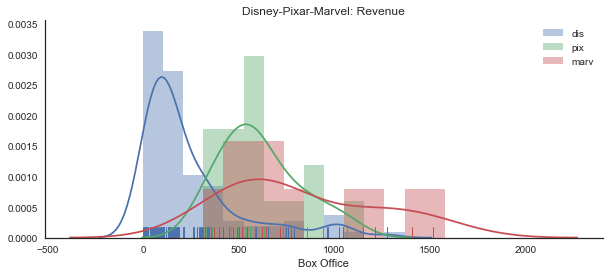

In [27]:
sns.set_style('white')
plt.figure(figsize=(10, 4))
binsr = np.linspace(0,2000,20)

var = {'dis':dis_only, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Disney-Pixar-Marvel: Revenue')
plt.xlabel('Box Office')
plt.legend()
sns.despine()

#### Though we see that Disney's box-office revenue is a lot more skewed to the left (a lot less) compared to Marvel and Pixar... 

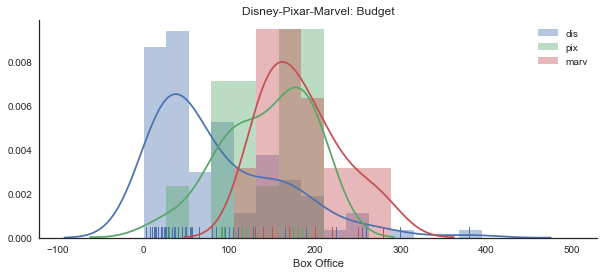

In [28]:
plt.figure(figsize=(10, 4))
binsb = np.linspace(0,500,20)

var = {'dis':dis_only, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True)
    
plt.title('Disney-Pixar-Marvel: Budget')
plt.xlabel('Box Office')
plt.legend()
sns.despine()

#### ... we also see that the budgets for Disney's movies are similarly skewed to the left relative to the other two studios'.
- Excluding ***SOME*** unwanted lower-budget films gives us a closer comparison.
    - 

In [29]:
# filter lower-budget films; filter high-revenue films (threshold = "Pocahontas")
temp = dis_only.copy()[dis_only['budg'].apply(lambda x: x >= 85)]
temp1 = dis_only.copy()[dis_only['rev'].apply(lambda x: x >= 345)]

# combine to include all high-budget films and low-budget films with high box office
# done to include a few classic Disney films i.e., "Lion King"
disonly = pd.DataFrame(columns=dis_only.columns)
disonly = pd.concat([temp, temp1]).drop_duplicates()

# only manipulating dis_only df, because MAINLY* only disney movies were affected
a = pixar_only.budg
print("Smallest budget from Marvel movies: $" + str(np.amin(marv_only.budg)) + ' million')
print("Smallest budget from Pixar movies: $" + str(np.amin(a[a!=30])) + ' million')
print('\t-Excluded movies with budget of $30m to include "Toy Story."')
pixar_only.sort_values('budg').head(2)

Smallest budget from Marvel movies: $130.0 million
Smallest budget from Pixar movies: $90.0 million
	-Excluded movies with budget of $30m to include "Toy Story."


,index,Title,year,rev,budg,prof,genres,production_companies,popularity,vote_average,vote_count,release_date
96,1373,Toy Story,1995,373.554033,30.0,343.554033,"Animation,Comedy,Family",Pixar Animation Studios,73.640445,7.7,5269,1995-10-30
58,335,Toy Story 2,1999,497.366869,90.0,407.366869,"Animation,Comedy,Family",Pixar Animation Studios,73.575118,7.3,3806,1999-10-30


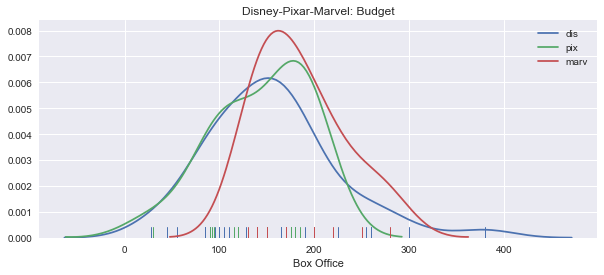

In [30]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 4))

var = {'dis':disonly, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True, hist=False)
    
plt.title('Disney-Pixar-Marvel: Budget')
plt.xlabel('Box Office')
plt.legend()
sns.despine()

Now we see that the budget distribution for Disney is much **more comparable** with the other two studios'.

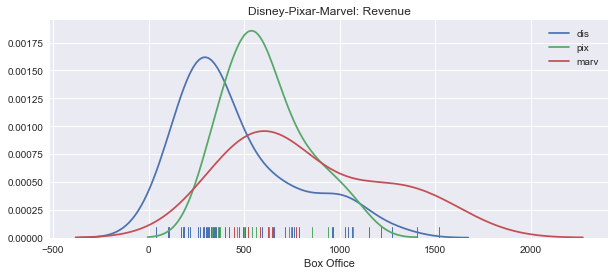

In [31]:
plt.figure(figsize=(10, 4))

var = {'dis':disonly, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True, hist=False)
    
plt.title('Disney-Pixar-Marvel: Revenue')
plt.xlabel('Box Office')
plt.legend()
sns.despine()

Once again utilizing our most-handiest of tools, the eye test, it appears Disney still underperforms relative to Pixar and Marvel.

In [32]:
print('count for: disney = ',  str(len(disonly)), '; pixar = ', str(len(pixar_only)), '; marvel = ', str(len(marv_only)))

count for: disney =  43 ; pixar =  16 ; marvel =  12


#### Since the individual studios have far less observations, combining the non-Disney studios and comparing that one portfolio of movies against Disney's movie library will make a better test.
- (maybe test individually afterwards if compelled)

In [33]:
marv_pixar = pd.concat([marv_only, pixar_only])

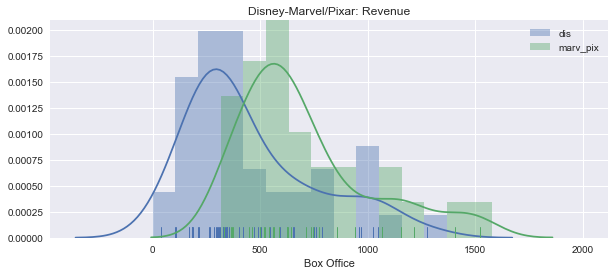

In [34]:
plt.figure(figsize=(10, 4))

var = {'dis':disonly, 'marv_pix':marv_pixar}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True, hist=True)
    
plt.title('Disney-Marvel/Pixar: Revenue')
plt.xlabel('Box Office')
plt.legend()
sns.despine()

Checking the distributions of the test for **normality...**

In [35]:
stats.shapiro(dis_only['rev'])

(0.7641255855560303, 1.93934937553486e-11)

In [36]:
stats.shapiro(marv_pixar['rev'])

(0.8805892467498779, 0.0041374037973582745)

The marv_pix.rev distribution has a Shapiro-Wilk p-value that is greater than the significance level of 0.05.  This means that marv_pix.rev distribution does not deviate from a normal distribution.<br> However, the disrev1.rev distribution does depart from a normal distribution, so the Mann-Whitney U-test will be used. 

***
### Test


In [37]:
stats.mannwhitneyu(disonly['rev'], marv_pixar['rev'])

MannwhitneyuResult(statistic=291.0, pvalue=0.00012949919833231204)

#### Using the mwu-test on the revenues of disney with marv+pixar returns a P-value that is much smaller than the significance level at 0.05.  <br>Therefore, we reject the null hypothesis of no significant difference.
***
#### At this point, we can continue to further filter the Disney-only movies to make it  as similar as possible to the other portfolio of movies (Marvel and Pixar are in very niche segments, very profitable ones at that).  

##### Jumping forward, if further variable/feature groupings provide similar test results, then we can make the conclusion that:
- Disney's performance has been driven by the successes of its *subsidiary studios*, as opposed to its main studio unit.

***
Disney was picked as the base-case studio for our exploration because Disney was the likeliest of the studios to be have significantly better performance than the others.
#### Ultimately, our goal is to uncover the factors that are driving the box office.  *The answer does not necessarily have to come from Disney, or any one studio*. 
***

#### Assuming further test results confirm our initial findings that subsidiaries are driving Disney's revenues, we also see that...

In [38]:
# taken from the-numbers.com; box-office share of major studios
# a much more complete dataset
share = pd.read_csv('studioshare.csv')
share.rename(columns={'Share':'Percentage'}, inplace=True)

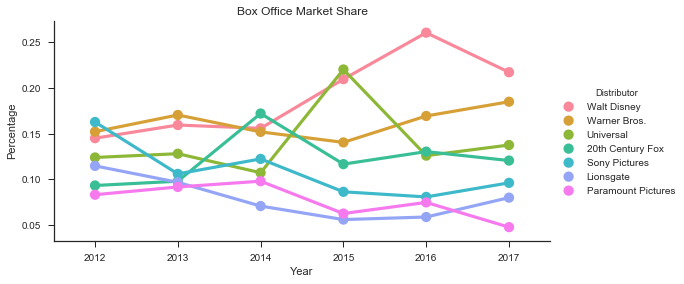

In [39]:
sns.set(style='ticks')
g = sns.factorplot(x='Year', y='Percentage', hue='Distributor', data=share, kind='point', aspect=2)
plt.title('Box Office Market Share')
plt.show()

#### ...Disney has been performing heads-and-shoulders above the other studios in recent years,

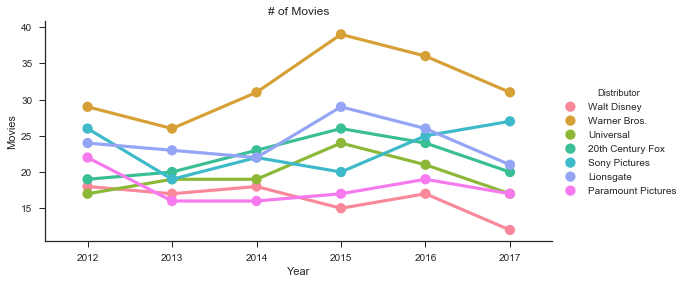

In [40]:
sns.set(style='ticks')
g = sns.factorplot(x='Year', y='Movies', hue='Distributor', data=share, kind='point', aspect=2)
plt.title('# of Movies')
plt.show()

#### doing so in spite of (or because of?) releasing the fewest films on average among the major studios (leading to an impressive average box office. 

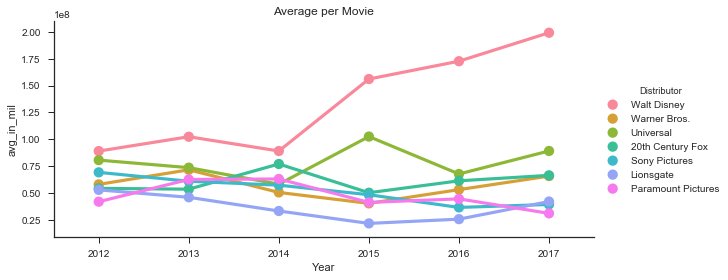

In [41]:
share['avg_in_mil'] = share['Gross']/share['Movies']

g=sns.factorplot(x='Year', y='avg_in_mil', hue='Distributor', data=share, kind='point', aspect=2.15)
plt.title("Average per Movie")
plt.show()

#### Since Disney is the best box-office performer by far, our base assumptions for the experiment will [continue to] be derived through Disney.

#### We can start by going into the type of movies Marvel/Pixar produce, as Marvel/Pixar is driving Disney's box office (assumed to have been confirmed; only one test was run supporting the statement). 

In [42]:
genres_t = list(set([a for b in tmdb1.genres.str.split(',') for a in b]))
genres_t.sort()
genres_t

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western']

In [43]:
genres_mp = list(set([a for b in marv_pixar.genres.str.split(',') for a in b]))
genres_mp.sort()
genres_mp

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Drama',
 'Family',
 'Fantasy',
 'Science Fiction']

#### Compared to the industry, Marvel and Pixar produce within a narrower range of genres.  That does not mean we can naturally assume these genres are superior as high-budget films are all they produce.  

In [44]:
a = marv_pixar.budg
print('The cheapest movie produced by Marvel/Pixar is ' + str(np.amin(a[a!=30])) + ' million dollars.  \nThis is compared to the industry budget average of ' + str(int(tmdb1.budg.mean())) + ' million dollars.')

The cheapest movie produced by Marvel/Pixar is 90.0 million dollars.  
This is compared to the industry budget average of 46 million dollars.


#### Controlling our variables and ensuring that our assumptions stay within the implied scope will reduce the chances of reaching an incorrect conclusion. 


Since checking for each genre might be too inclusive, only a few genres will be included to the filter...

In [45]:
for genre in genres_t:
    tmdb1[genre] = tmdb1['genres'].str.contains(genre).apply(lambda x:1 if x else 0)

In [46]:
only_mp = tmdb1.loc[marv_pixar['index'], :].sort_index()

# non-Marvel/Pixar movies
mpindex = only_mp.index
no_mp = tmdb1.drop(mpindex)

In [47]:
# creating updated dfs with 'genres' feature included
only_marv = tmdb1.loc[marv_only['index'], :].sort_index()
only_pix = tmdb1.loc[pixar_only['index'], :].sort_index()

In [48]:
only_marv.loc[:, 'Action':'Western'].astype(bool).sum(axis=0).sort_values(ascending=False).head(4)

Action             12
Adventure          12
Science Fiction    10
Fantasy             2
dtype: int64

In [49]:
only_pix.loc[:, 'Action':'Western'].astype(bool).sum(axis=0).sort_values(ascending=False).head(7)

Animation    16
Family       16
Comedy       11
Adventure     7
Action        2
Fantasy       2
Drama         1
dtype: int64

Marvel and Pixar movies do not have much 'genres' (variable & features) in common.  The main drivers, or core focuses, for each studio should be then determined individually.
<br>For Pixar movies, including 'Animation' and 'Family' and filtering by budget seems appropriate and sufficient for comparisons, simple enough.
<br>On the other hand, the key genre in Marvel movies is likely a combination of a few.  
- 'Action' and 'Adventure' show up in all Marvel movies, but Marvel movies are not necessarily representative of all 'Action'/'Adventure' movies that have ever been released.
- 'Science Fiction' shows up in 10 of 12 films (not including the two *Thor* movies, both of which relatively underperformed), but filtering by only 'Science Fiction' would include films that do not resemble a Marvel movie.
- 'Action' and 'Adventure' is nearly synonymous and interchangeable.  There is a distinction, but one that might have been overlooked occasionally (incomplete/incorrect database when dataset was retrieved by contributors).
    - Therefore, creating a movie portfolio emulating Marvel's would include the genre combinations of ('Action' and/or 'Adventure) and 'Science Fiction', along with budget considerations.

In [222]:
act_scfi = no_mp.groupby(['Action', 'Science Fiction']).get_group((1,1))
adv_scfi = no_mp.groupby(['Adventure', 'Science Fiction']).get_group((1,1))
ani_ = no_mp.groupby('Animation').get_group(1)

In [223]:
box_off_mpgenres = pd.concat([act_scfi, adv_scfi, ani_])
box_off_mpgenres = box_off_mpgenres.drop_duplicates().sort_index()

In [224]:
# box_off_mpgenres = entire box office (of the given dataset), matching marvel/pixar genres
# budget >= $85m
box_off_mpgenres_85 = box_off_mpgenres[box_off_mpgenres.budg >= 85]

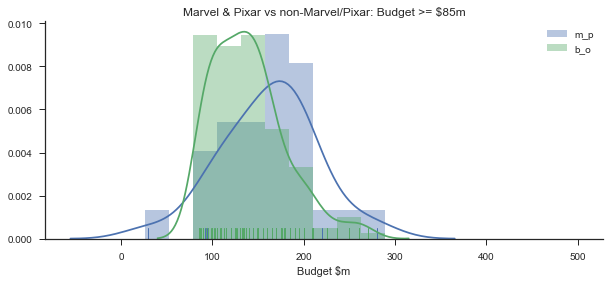

In [225]:
plt.figure(figsize=(10, 4))

var = {'m_p':only_mp, 'b_o':box_off_mpgenres_85}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True)
    
plt.title('Marvel & Pixar vs non-Marvel/Pixar: Budget >= $85m')
plt.xlabel('Budget $m')
plt.legend()
sns.despine()

#### Having already filtered out for only "blockbuster" films \(<=\$85 million\), the distribution of budgets does not have as much overlap as with the Disney-Marvel-Pixar distribution of budgets.
- It would be possible to filter out more observations from the non-Marvel/Pixar distribution, <br>as there are only two observations in the Marvel/Pixar distribution with a** budget '<' \$100m**, so we could increase our threshold level accordingly
    - Used $90m previously for the Dis-Marv-Pix comparison

In [226]:
# box_off_mpgenres = entire box office (of the given dataset), matching marvel/pixar genres
# budget >= $100m
box_off_mpgenres_100 = box_off_mpgenres[box_off_mpgenres['budg'] >= 100]

In [227]:
print('The df only went from ', str(len(box_off_mpgenres_85)), ' to ', str(len(box_off_mpgenres_100)), 'observations.')

The df only went from  149  to  128 observations.


Even if less observations were eliminated than preferred...

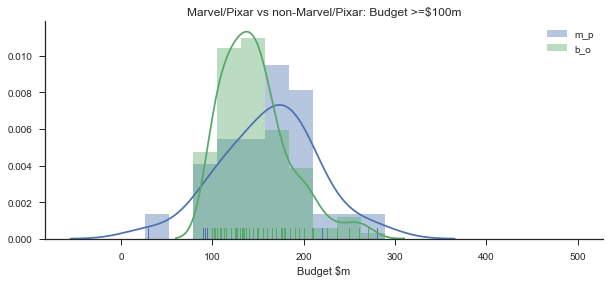

In [228]:
plt.figure(figsize=(10, 4))

var = {'m_p':only_mp, 'b_o':box_off_mpgenres_100}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True)
    
plt.title('Marvel/Pixar vs non-Marvel/Pixar: Budget >=$100m')
plt.xlabel('Budget $m')
plt.legend()
sns.despine()

... and the updated Box-Office distribution looks identical, the new df with budget '>=' \$100m will be used regardless; 
- as a handicap administered by the tester,
- as previously, the budget **'>'** \$90m, whereas now, the budget **'>='**\$100m.

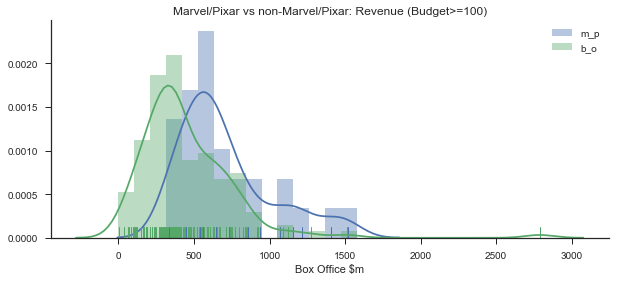

In [229]:
plt.figure(figsize=(10, 4))

var = {'m_p':only_mp, 'b_o':box_off_mpgenres_100}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel/Pixar vs non-Marvel/Pixar: Revenue (Budget>=100)')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

The Mann-Whitney U test will continued to be employed (instead of normalizing the distribution and using a T-test).

### Test 
***

In [230]:
stats.mannwhitneyu(only_mp['rev'], box_off_mpgenres_100['rev'])

MannwhitneyuResult(statistic=866.0, pvalue=9.600402209762366e-06)

#### Results indicate that there is a significant difference in the mean of Marvel/Pixar movies and the non-Marvel/Pixar movies.
There are a couple issues with this test.
<br><br>
The first is that there is a significant difference in sample sizes.
<br>
Also, this comparison is ***only* in the genres that Marvel/Pixar operate in**.  While these genres are Marvel/Pixar's specializations, they are not necessarily any other studios' core focus.
<br><br>
Therefore, while we can use this test results to confirm Marvel/Pixar are the industry leaders in their respective genres, we **cannot determine** that Marvel/Pixar are better production studios overall than any other studio.
<br>
To be able to make that determination, there must be another test using different metrics or groupings.
<br>

#### However, our initial focus was to see if the "genres" Marvel/Pixar operate in are better than "other genres".  
- In order to determine if the genres that Marvel/Pixar operate in are truly the "better" genres, we must **test** the **box office with the genres** against the **box office without the genres.**

#### There is a distinction between: a) Marvel/Pixar being the box-office drivers, and b) the GENRES of Marvel/Pixar being the box-office drivers. 

While we have already performed a test on Disney and Disney's subsidiaries (Marvel/Pixar), that test did not filter out Disney's movies to match the genres of Marvel/Pixar.

In [231]:
# pulling Disney only movies with matching genres as marvel/pixar
# budg >= 85
dis_mpgenres_85 = box_off_mpgenres_85.groupby('dis').get_group(1)

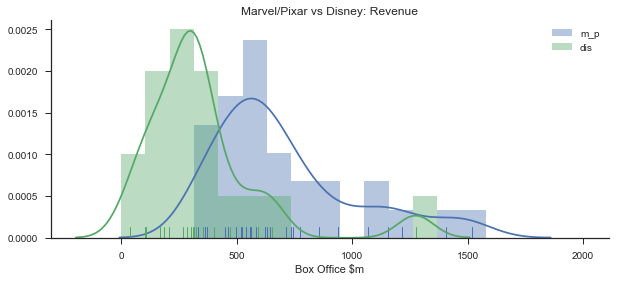

In [232]:
plt.figure(figsize=(10, 4))

var = {'m_p':only_mp, 'dis':dis_mpgenres_85}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel/Pixar vs Disney: Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

### Test
***

In [233]:
stats.mannwhitneyu(only_mp['rev'], dis_mpgenres_85['rev'])

MannwhitneyuResult(statistic=67.0, pvalue=8.423778733916771e-06)

When testing Disney for the Marvel/Pixar genres, **Disney performs slightly better than the other studios in the "genre groupings" that Marvel/Pixar operate in**, but stil significantly less than Marvel/Pixar.<br><br>
This does not necessarily signifiy anything bad, as it makes perfect sense to consider merger/acquisitions that **cover up your weaknesses**, which is what Disney did when they **purchased Marvel**.<br>
However, when it came to purchasing **Pixar**, the two studios' **main offering was the same: "Animation"**.
***

In [234]:
# not using genre-filtered df 
disonly['Animation'] = disonly['genres'].str.contains('Animation').apply(lambda x:1 if x else 0)
dis_ani = disonly.copy().groupby('Animation').get_group(1)
print("The 'Animation' movies of Disney(", str(len(dis_ani)), ") and Pixar(", str(len(pixar_only)), ") are very close in sample sizes,\nhowever, the sample sizes are not very large, which may cause the test results to be less reliable.")

The 'Animation' movies of Disney( 19 ) and Pixar( 16 ) are very close in sample sizes,
however, the sample sizes are not very large, which may cause the test results to be less reliable.


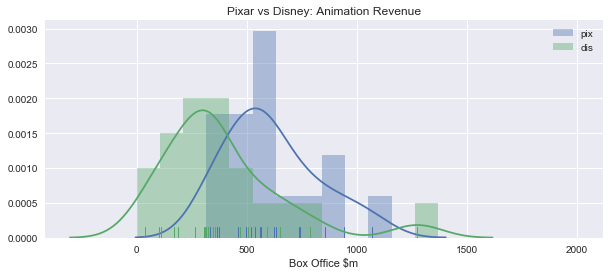

In [235]:
sns.set(style='darkgrid')
plt.figure(figsize=(10, 4))

var = {'pix':pixar_only, 'dis':dis_ani}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Pixar vs Disney: Animation Revenue')
plt.xlabel('Box Office $m')
plt.legend()

sns.despine()

### Test
***

In [236]:
stats.mannwhitneyu(pixar_only['rev'], dis_ani['rev'])

MannwhitneyuResult(statistic=60.0, pvalue=0.0012233041578901714)

#### From the test results, Pixar outperforms Disney in the quintessential genre for the two studios ('Animation'). 
However, even with the visual to corroborate our test findings, as mentioned earlier, the **small sample sizes does lead to some doubts** about the validity of our results, as it is less likely that the distribution is representative of the actual "population" than larger sample sizes.  <br><br> However, when we look at Disney's box office distribution, there is one observation/movie that performed much better than other Disney movies.
<br>Also, the threshold level for Disney's budget was set higher relative to Pixar.<br><br>Therefore, it can be ***crudely* assumed** that Disney is more likely to have observations that underperform compared to Pixar than outperform .
<br><br>We can say then that Disney made a very smart choice in acquiring Pixar as well.

***
*Verifying if there is a difference in Marvel and Disney...*

In [237]:
dis_nonani = disonly.copy().groupby('Animation').get_group(0)

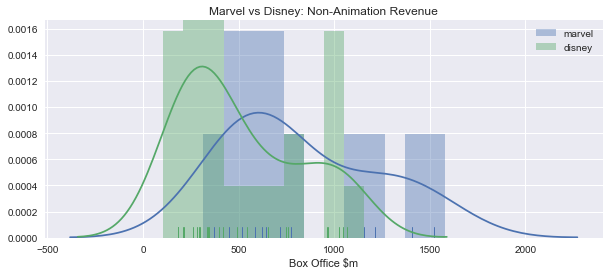

In [238]:
plt.figure(figsize=(10, 4))

var = {'marvel':marv_only, 'disney':dis_nonani}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel vs Disney: Non-Animation Revenue')
plt.xlabel('Box Office $m')
plt.legend()

sns.despine()

### Test
***

In [239]:
stats.mannwhitneyu(marv_only['rev'], dis_nonani['rev'])

MannwhitneyuResult(statistic=67.0, pvalue=0.005126588307818575)

#### Test results indicate that Marvel outperforms Disney when comparing 'non-Animation' movies and 'Animation' movies.
- did not match genres as key Disney movies would have been excluded (i.e., "Pirates of the Caribbean")
<br>

Marvel and Pixar are both "better" studios than Disney, per the tests.
***

<br>
##### Testing Pixar then Marvel against the other studios


In [240]:
# assigning the 'genres features' to each studio

list_studiosdf = [fox, wb, univ, sony, para, lgf]

for studio in list_studiosdf:
    for genre in genres_t:
        studio[genre] = studio['genres'].str.contains(genre).apply(lambda x:1 if x else 0)

In [241]:
colus = ['Title', 'kpi', 'metric', 'studio']


# 'Animation' movies
tmdba1 = tmdb1.copy().groupby('Animation').get_group(1)
tmdba = tmdba1[tmdba1['budg']>=85]

In [242]:
# slice 1:-1 to exclude Disney and Lionsgate (has no 'Animation')
studios_rev_a = ftr_groupby(list_studios[1:-1], ('Title', 'rev'), tmdba)
studios_budg_a = ftr_groupby(list_studios[1:-1], ('Title', 'budg'), tmdba)
studios_concan_a0 = pd.concat([studios_rev_a, studios_budg_a])

# adding in disney and pixar separately 

In [243]:
# using previously created dfs to join to 
pixar_only['studio'] = 'pixar'
dis_ani['studio'] = 'dis'

# update kpi/metric with every use (run from the start)
dis_ani['kpi'] = dis_ani['budg'].copy()
dis_ani['metric'] = 'budg'
pixar_only['metric'] = 'budg'
pixar_only['kpi'] = pixar_only['budg'].copy()

# concantenating studios
studios_concan_a1 = pd.concat([dis_ani.loc[:, colus], studios_concan_a0, pixar_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [244]:
# add dis & pixar rev/budg separately

dis_ani['kpi'] = dis_ani['rev'].copy()
pixar_only['kpi'] = pixar_only['rev'].copy()
dis_ani['metric'] = 'rev'
pixar_only['metric'] = 'rev'

# concantenating
studios_concan_a = pd.concat([dis_ani.loc[:, colus], studios_concan_a1, pixar_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


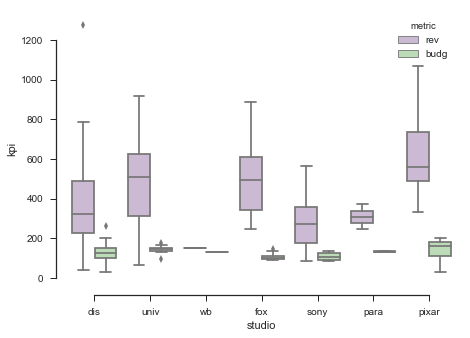

In [245]:
sns.set(style="ticks", )
ax, fig = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="studio", y='kpi', hue='metric', data=studios_concan_a, palette="PRGn")
sns.despine(offset=10, trim=True)

Instead of testing each studio with Pixar, testing Universal and Fox would be all that is required to determine if Pixar is superior to the other studios.
### Test
***

In [246]:
# 'Animation' for Universal and Fox
univ_a = univ.groupby('Animation').get_group(1)
fox_a = fox.groupby('Animation').get_group(1)

In [247]:
# budget>=85
univ_a85 = univ_a[univ_a['budg']>=85]
fox_a85 = fox_a[fox_a['budg']>=85]

In [248]:
stats.mannwhitneyu(pixar_only['rev'], univ_a85['rev'])

MannwhitneyuResult(statistic=125.0, pvalue=0.06771024362601179)

In [249]:
stats.mannwhitneyu(pixar_only['rev'], fox_a85['rev'])

MannwhitneyuResult(statistic=44.0, pvalue=0.11621429326753663)

##### Pixar is not significantly different from the 'Animation' movies of either Universal or Fox.

Comparing Pixar with the Box Office as a whole would undoubtedly strengthen Pixar's p-value, as the other 'studios' bring down the average revenue of 'Animation' films.

However, as mentioned earlier about the strengths and weaknesses of each studio, testing with the other industry leaders is preferred in order to achieve a stronger confirmation.

Given that Pixar's distribution is still on the higher side, we may say that though Pixar's movies are **not significantly better than every studio's 'Animation' films**, Pixar is still *the* leader when it comes to 'Animation'.
***

##### Testing Marvel against other 'studios'

In [250]:
colus = ['Title', 'kpi', 'metric', 'studio']


# non-Animation movies; budg>=85
tmdbna0 = tmdb1.copy().groupby('Animation').get_group(0)
tmdbna = tmdbna0[tmdbna0['budg']>=100]

In [251]:
studios_rev_na = ftr_groupby(list_studios[1:], ('Title', 'rev'), tmdbna)
studios_budg_na = ftr_groupby(list_studios[1:], ('Title', 'budg'), tmdbna)
studios_concan_na0 = pd.concat([studios_rev_na, studios_budg_na])

In [252]:
marv_only['studio'] = 'marv'
dis_nonani['studio'] = 'dis'

# update kpi/metric with every use
dis_nonani['kpi'] = dis_nonani['budg'].copy()
dis_nonani['metric'] = 'budg'
marv_only['metric'] = 'budg'
marv_only['kpi'] = marv_only['budg'].copy()

studios_concan_na1 = pd.concat([dis_nonani.loc[:, colus], studios_concan_na0, marv_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [253]:
dis_nonani['kpi'] = dis_nonani['rev'].copy()
marv_only['kpi'] = marv_only['rev'].copy()
dis_nonani['metric'] = 'rev'
marv_only['metric'] = 'rev'

studios_concan_na = pd.concat([dis_nonani.loc[:, colus], studios_concan_na1, marv_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


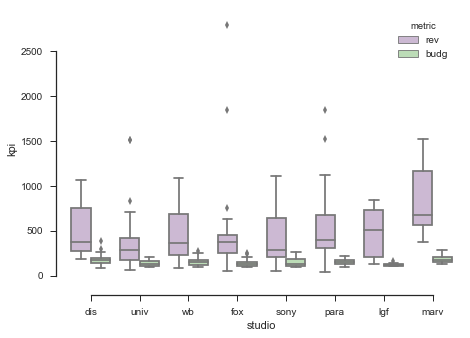

In [255]:
sns.set(style="ticks", )
ax, fig = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="studio", y='kpi', hue='metric', data=studios_concan_na, palette="PRGn")
sns.despine(offset=10, trim=True)

It does not appear necessary to test the studios against Marvel, as Disney seems to have the best distribution out of the rest (supported by the histogram below), and we know from before, Marvel is superior to Disney.
***
##### Testing Marvel and Pixar individually against the rest of Box Office in their respective 'genres' and as a whole

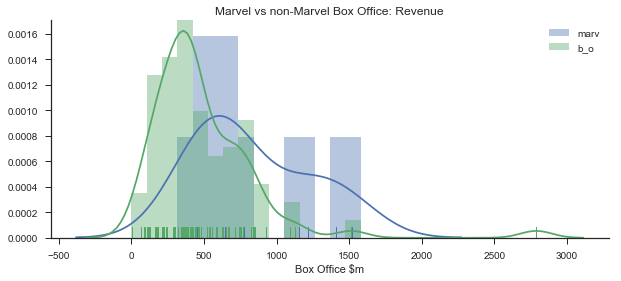

In [261]:
plt.figure(figsize=(10, 4))

bo_marvgenres = pd.concat([act_scfi, adv_scfi]) # already no_mp
bo_marvgen = bo_marvgenres[bo_marvgenres['budg']>=100]

var = {'marv':marv_only, 'b_o':bo_marvgen}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel vs non-Marvel "non-Animation": Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

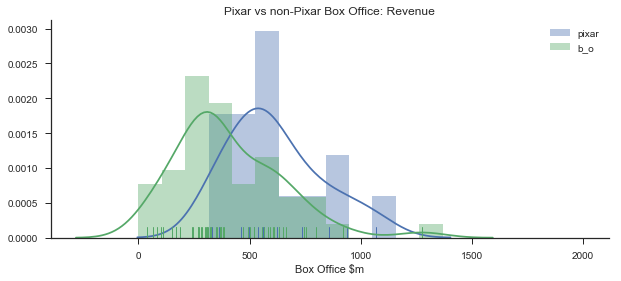

In [262]:
plt.figure(figsize=(10, 4))

ani_100 = ani_[ani_.budg>=100]

var = {'pixar':pixar_only, 'b_o':ani_100}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Pixar vs non-Pixar "Animation": Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

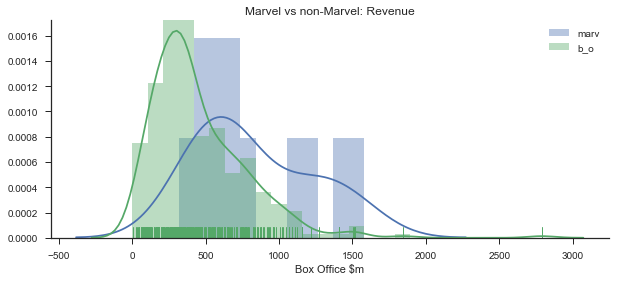

In [263]:
plt.figure(figsize=(10, 4))

tmdb100 = tmdb1[tmdb1.budg >=100]

var = {'marv':marv_only, 'b_o':tmdb100}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel vs non-Marvel "non-Animation": Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

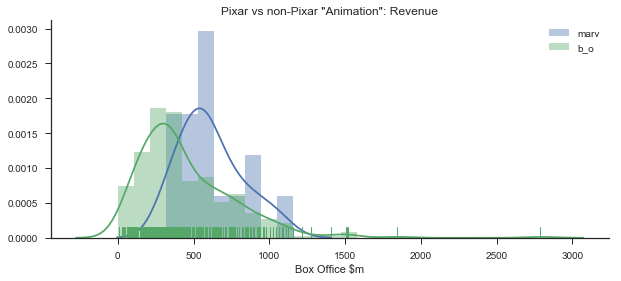

In [265]:
plt.figure(figsize=(10, 4))

tmdb100 = tmdb1[tmdb1.budg >=100]

var = {'marv':pixar_only, 'b_o':tmdb100}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Pixar vs non-Pixar "Animation": Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

### Test
***

In [266]:
stats.mannwhitneyu(marv_only.rev, tmdb100.rev)

MannwhitneyuResult(statistic=755.0, pvalue=0.00019091481077997106)

In [267]:
stats.mannwhitneyu(pixar_only.rev, tmdb100.rev)

MannwhitneyuResult(statistic=1452.0, pvalue=0.001888948165765181)

In [268]:
stats.mannwhitneyu(marv_only.rev, bo_marvgen.rev)

MannwhitneyuResult(statistic=359.0, pvalue=0.0006706326651014869)

In [269]:
stats.mannwhitneyu(pixar_only.rev, ani_fami100.rev)

MannwhitneyuResult(statistic=181.0, pvalue=0.00171332103143937)

**Marvel and Pixar both perform better than the Box Office as a whole, and when comparing to their respective 'genres'.**
<br><br>We have covered the performance of Marvel and Pixar against the Box Office and a few individual 'studios', and<br>
**with this, one of the questions (if Marvel and Pixar are drivers of the Box Office) is just about fully answered and will be discussed later.**
***
The next question is in regards to the **'genres'** of Marvel/Pixar being the **Box Office drivers.**
##### Testing Box Office through groupby(Marvel and Pixar genres)

In [270]:
act_scfi1 = tmdb1.groupby(['Action', 'Science Fiction']).get_group((1,1))
adv_scfi1 = tmdb1.groupby(['Adventure', 'Science Fiction']).get_group((1,1))
ani_1 = tmdb1.groupby(['Animation', 'Family']).get_group((1,1))

# Box Office of marvel's and pixar's genres
# includes marvel and pixar
mp_bo = pd.concat([act_scfi1, adv_scfi1, ani_1])
mp_bo = mp_bo.drop_duplicates().sort_index()
mp_bo1 = mp_bo[mp_bo.budg>=85]

# box_off_mpgenres does not include marvel/pixar

In [271]:
mpbo_ind = mp_bo.index
non_mpbo = tmdb1.drop(mpbo_ind)

non_mpbo1 = non_mpbo[non_mpbo.budg>=85]

### Test
***

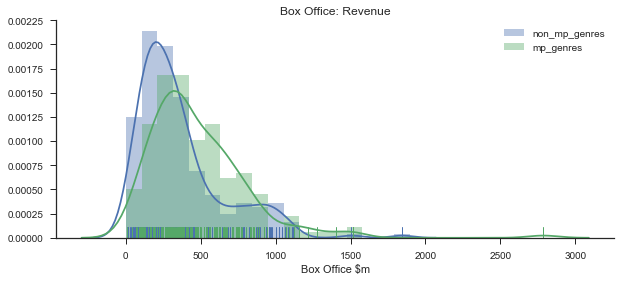

In [272]:
# includes Marvel and Pixar movies

plt.figure(figsize=(10, 4))

var = {'non_mp_genres':non_mpbo1, 'mp_genres':mp_bo1}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [273]:
stats.mannwhitneyu(mp_bo1.rev, non_mpbo1.rev)

MannwhitneyuResult(statistic=14514.5, pvalue=1.3241582593312192e-06)

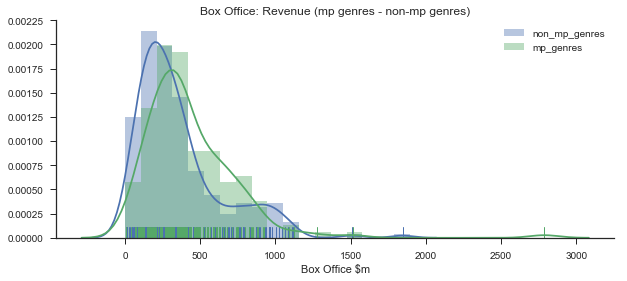

In [274]:
# does not include Marvel and Pixar movies

plt.figure(figsize=(10, 4))

var = {'non_mp_genres':non_mpbo1, 'mp_genres':box_off_mpgenres_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue (mp genres - non-mp genres)')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [275]:
stats.mannwhitneyu(box_off_mpgenres_85.rev, non_mpbo1.rev)

MannwhitneyuResult(statistic=13961.5, pvalue=0.0004112452123619021)

Regardless of whether Marvel and Pixar movies are included or not, **the Box Office with Marvel/Pixar 'genres' is significantly better than non-Marvel/Pixar 'genres'.**
***
##### Testing Marvel and Pixar 'genres' separately

In [276]:
marvgen_bo = pd.concat([act_scfi1, adv_scfi1], axis=0)
marvgen_bo_85 = marvgen_bo[marvgen_bo['budg']>=85]

In [277]:
nonmarvgen_bo = tmdb1.drop(marvgen_bo.index)
nonmarvgen_bo_85 = nonmarvgen_bo[nonmarvgen_bo['budg']>=85]

### Test

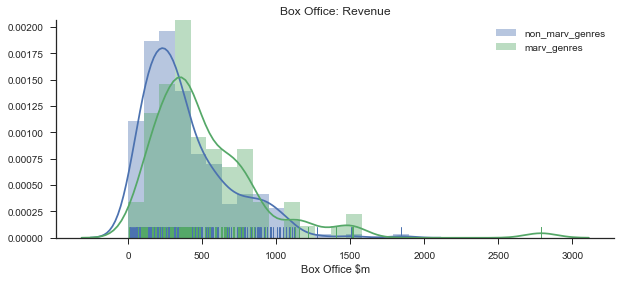

In [216]:
# includes Marvel

plt.figure(figsize=(10, 4))

var = {'non_marv_genres':nonmarvgen_bo_85, 'marv_genres':marvgen_bo_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [203]:
stats.mannwhitneyu(marvgen_bo_85.rev, nonmarvgen_bo_85.rev)

MannwhitneyuResult(statistic=19179.5, pvalue=2.6221978955284797e-06)

In [215]:
nmarvgen_bo_85 = marvgen_bo_85.drop(marv_only.set_index('index').index)

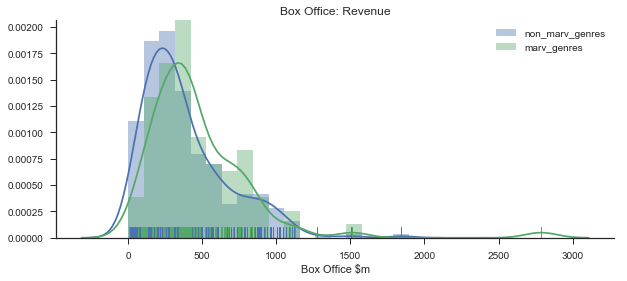

In [218]:
# does not include Marvel

plt.figure(figsize=(10, 4))

var = {'non_marv_genres':nonmarvgen_bo_85, 'marv_genres':nmarvgen_bo_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [219]:
stats.mannwhitneyu(nmarvgen_bo_85.rev, nonmarvgen_bo_85.rev)

MannwhitneyuResult(statistic=18373.5, pvalue=0.0005311436910908813)

The **'genres' of Marvel show significantly better performance** at the Box Office than the other 'genres'.
    - true including/excluding Marvel movies
***
##### Testing Pixar genres

In [284]:
pixgen_bo = ani_1.copy() # same as how marvgen_bo is created
pixgen_bo_85 = pixgen_bo[pixgen_bo['budg']>=85]

In [285]:
non_pixgen_bo = tmdb1.drop(pixgen_bo.index)
non_pixgen_bo_85 = non_pixgen_bo[non_pixgen_bo['budg']>=85]

### Test
***

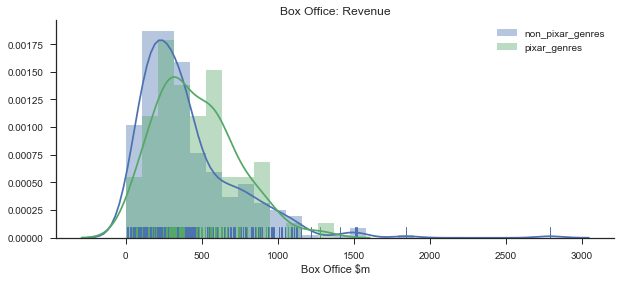

In [286]:
# includes Marvel

plt.figure(figsize=(10, 4))

var = {'non_pixar_genres':non_pixgen_bo_85, 'pixar_genres':pixgen_bo_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue')
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [287]:
stats.mannwhitneyu(non_pixgen_bo_85.rev, pixgen_bo_85.rev)

MannwhitneyuResult(statistic=9443.0, pvalue=0.007635719859348923)

Normally, we would **continue** with the exploration/discovery of the dataset until there is a **complete set of assumptions** for the experiment.
However, ***we will stop the exploration/discovery section here**, now that the **first core assumption has been found.**

We will come back to this later during the experiment section; for now, based off our results, we assume that if trailers 

When we perform tests for the actual experiment, we are hoping to see if [manipulating] certain variables (the ones we have gathered from exploration) will result in a significant difference in the dependent variable as expected.  i.e.,
- a variable we can consider is the seasonality of a movie's release date
- does changing the time of year a movie is released lead to a significant departure from the expected mean of the dependent variable (revenue)?
- is there a preferred/better time of year for movie releases?


### One thing not accounted for: parental guidance.  Comparing PG movies with R movies, even if budgets are similar, is not ideal (aka incorrect)

pre-test: expectations, reasons<br>
post-test: satisfied?, reasons

Considering the variables that were being analyzed during exploration, 'production_companies' and 'genres', and others that essentially make up what a movie is ('actors', 'keywords'), <br><br>
***How can these variable be manipulated without also drastically changing the product itself?***<br> <br>
**Trailers** are where consumers get most of their information about a movie, and will be where most of the manipulation has to take place.<br>
Altering a **variable** on a printed medium is simple enough, but how can the genre of a trailer be manipulated without also changing the genre of the movie? <br>Well, the filmmaker themselves are not always directly involved in making trailers, which has more to do with marketing and may be considered out of the filmmaker's expertise. So, 
- trailers do not always include clips that make the final cut of the movie, and
- trailers can include scenes that evoke certain genres over others, but not one that is consistent with the entire movie.

The first point has become a recent topic of contention among [moviegoers](https://www.independent.co.uk/arts-entertainment/films/news/suicide-squad-fan-suing-studio-false-advertising-lack-of-joker-scenes-jared-leto-warner-bros-a7180231.html), and even among the [actors](https://www.cinemablend.com/news/1546480/jared-leto-is-apparently-really-upset-about-suicide-squad-heres-what-happened) themselves, when the final cut of a movie excludes a lot of what was the most anticipated material from the movie in the first place. 

The second point - introducing some first-hand, personal experiences to the research - can best be symbolized by Edgar Wright's *Baby Driver*.  <br>
When I watched the trailer when it first came out, I got a bit more of an overall happy vibe from the [trailer](https://www.youtube.com/watch?v=D9YZw_X5UzQ), in parts because of the music, the [color grading](https://www.youtube.com/watch?v=hpWYtXtmEFQ), and because the characters are doing some very [stupid things](https://www.youtube.com/watch?v=kOnQocd799Y) in a crime movie.  <br> 
The movie was darker than expected, but it felt forced and awkward.  The [review](https://www.nytimes.com/2017/06/27/movies/baby-driver-review-edgar-wright-ansel-elgort.html) insists you will go on a "genre ride" and that "it's easy to go with Mr. Wright's flow, partly because he rarely steps off the gas".<br>
For those same reasons, I thought the movie suffered from an identity crisis.  For each genre present in the movie, there were a couple scenes taken to the extreme just to be able to "include" that genre.  <br>
At times, the movie was unattractively brazen about it (all the singing and dancing for one); at other times, the characters' actions were just baffling (fingerprints everywhere).
<br>Needless to say more, I did not particularly enjoy the movie.
- (of course, the flip side of this is that I read that exact review **before** I watched the movie, which makes that review an influencing variable as well)

Considering that such instances of trailer-to-movie manipulation does exist, then that can be transferred over in an actual experiment setting. (this trailer-to-movie manipulation would be able to manipulate just about all variables)<br>

Though manipulating trailers would be the preferred for all variables, it is more doable for some variables than others.
- "Movie test-screenings" would be even less feasible, and more complicated to manipulate variables for 20 minutes of uninterrupted content than a 2 minute collection of scene cuts.

"Manipulating" variables by changing words on a paper can be done simply enough, but the impact of that form of manipulation would first have to be captured and significant enough relative to the impact of manipulating variables in a digital medium to be used.
- possibly can be done simultaneously

#### To summarize briefly, the effects of some variable-manipulations can be captured simply through a printed medium, whereas other variable-manipulations must be done through a digital medium, but it will not always be possible for all variables\*. 


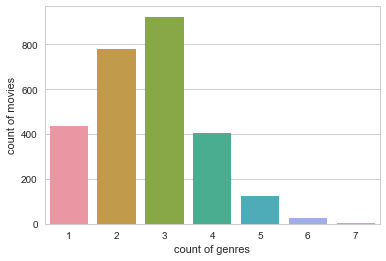

In [107]:
tmdb_gen = tmdb1['genres'].apply(lambda x: len(x.split(',')))

sns.set_style('whitegrid')
ax = sns.countplot(x=tmdb_gen)
ax.set(xlabel='count of genres', ylabel='count of movies')
plt.show()

\* Not all genres can be manipulated, erased, or hidden in a trailer.  It would take a great amount of work to hide the fact that a Star Wars movie is gonna be based in science fiction.  It could be done theoretically, but the finished product might not resemble a trailer.
<br>Movies are more likely to have a few genres than one, but there are still quite a few movies with just one genre.

In both cases where at least one genre has to exist in the trailer, then muting that particular genre in the trailer in favor of another genre (may not make sense for all genres; may not necessarily care about all genres) appears to be the best option when completely hiding a genre is not possible.

### Experiment

Samples will be randomly selected and randomly assigned to two groups, the control and the experiment. 
- Samples are trailers for movies

The control group will be exposed to variables in their original state, while the experiment group will be exposed to manipulated variables.<br>
(each group gets exposed to a different value of a variable?)
- manipulate the variable 'genre' in the trailers to include 'Sci-Fi'

The question: How many times would they watch movie in theaters? 
    (not just, would they watch the movie in theaters?)
    How likely are they to watch the movie? 

Pretests may be in the form of simple surveys of moviegoing habits...?
(not able to compared with test results, different scope)
- are not implemented.
(pretest would be... give both groups exact same trailer, how many times would they watch movie in theaters? and then manipulate variables and ask again?)
(or give different trailers from the start)?


Trailers are manipulated based on which variables' effect we are hoping capturing for that particlar test (all independent variables that can be manipulated will be eventually).

#### Variables
'Actors' - since trailers do not need to include too many scenes of the main actors, they can be manipulated as well; or vice versa, trailers can highlight an actor who [dies in the first 12 minutes](https://en.wikipedia.org/wiki/G.I._Joe:_Retaliation) of the film. 
<br>realistically, the test for 'actors' will likely be restricted to surveys 
 - or show participants audition tapes? (limits possible values to pool of applicants)
'production_companies' (studios) - easily manipulated, switch out the studio logos that are shown 
'genres' - talked about earlier, able to be manipulated as well
'keywords' & 'tagline' - can be manipulated through trailers similar to 'genres'



The test cannot simply ask participants what they think would make the movie better (adding this genre, replacing this actor with this one, etc). <br> Realistically, a product should have everything the consumer wants or expects from such a product, but any suggestions, expectations, or desires they express is [not all too reliable.](https://www.telegraph.co.uk/films/2016/04/14/in-2006-nobody-wanted-heath-ledger-to-play-the-joker/)
- (but still, should test contain survey something to the effect of, what do you think would improve the movie?)

Tests must contain manipulation and capture the effect of that manipulation.

Ultimately, the variable we are monitoring is revenue - or a metric derived from revenue - and the participants' response must pertain to that end.  
Therefore, the question 



In [ ]:
studios = list(set(a for b in tmdb['production_companies'].str.split(',') for a in b))
studios1 = list(set(a for b in tmdb1['production_companies'].str.split(',') for a in b))

In [ ]:
for s in studios:
    if 'Fox' in s:
        print(s)

In [ ]:
for s in studios1:
    if 'Disney' in s:
        print(s)

#### The sample sizes are pretty far apart, get proportion/count of Marvel/Pixar and get sample from non-Marvel/Pixar using that distribution proportion/count

In [ ]:
mp_budg_prptn = np.where(only_mp['budg']>=250, 250,
                         np.where(only_mp['budg']>=200, 200,
                                  np.where(only_mp['budg']>=150, 150,
                                        100)))

percentage = lambda b: len(b) / float(len(mp_budg_prptn))

In [ ]:
ax = sns.countplot(x=mp_budg_prptn, palette='Set3')
ax.set(xlabel='in $ millions', ylabel='count', title='Count of Budget Size')
sns.despine()
plt.show()

In [ ]:
ax = sns.barplot(x=mp_budg_prptn, y=mp_budg_prptn, estimator=percentage, palette='Set3')
ax.set(xlabel='in $ millions', ylabel='percent', title='Proportion of Budget Size')
sns.despine()
plt.show()

In [ ]:
temp = tmdb1.groupby('Action')['rev', 'budg'].mean()
temp1 = tmdb1.groupby('Adventure')['rev', 'budg'].mean()
temp1 = pd.concat([temp, temp1], axis=0)
temp1

In [ ]:
temp['genre'] = temp.index.name

In [ ]:
# appropriate way to create empty DF
gg_1 = pd.DataFrame()
for g in genres_t:
    temp = tmdb1.groupby(g)['rev', 'budg'].mean()
    temp['genre'] = temp.index.name
    if gg_1.empty == True:
        gg_1 = pd.DataFrame(temp)
    else:
        gg_1 = pd.concat([gg_1, temp], axis=0)

In [ ]:
gg_1

In [ ]:
tmdb1['r/b'] = round(tmdb1['rev']/tmdb1['budg'],2)

In [ ]:
# take this up
tmdb1['scale'] = np.where(tmdb1['budg']>=100, 'block', 
                              np.where(tmdb1['budg']>=65, 'mid', 
                                       np.where(tmdb1['budg']>=30, 'small', 
                                                'indie')))

['scale', ]

In [ ]:
tmdb1['r/b'] = round(tmdb1['rev']/tmdb1['budg'],2)
tpract = tmdb1[tmdb1['r/b'] < 10]
tpract1 = tpract[['r/b', 'vote_average', 'vote_count', 'scale']]

In [ ]:
tmdb1['scale'] = np.where(tmdb1['budg']>=100, 'block', 
                              np.where(tmdb1['budg']>=65, 'mid', 
                                       np.where(tmdb1['budg']>=30, 'small', 
                                                'indie')))

In [ ]:
g= sns.lmplot(x='vote_average', y='r/b', hue='scale', col='scale', data=tpract1, aspect=.5)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.regplot(x='vote_average', y='r/b', data=tpract1)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.regplot(x='vote_count', y='r/b', data=tpract1)

In [ ]:
dis['r/b'] = dis['rev']/dis['budg']
dis_pract = dis[['r/b', 'vote_average', 'vote_count']]

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.regplot(x='vote_average', y='r/b', data=dis_pract)

In [ ]:
g = sns.lmplot(x='')

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.regplot(x='vote_average', y='rev', data=dis)

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.regplot(x='vote_count', y='rev', data=dis)

In [ ]:
# # normalizing
# for g in dis_pract.columns:
#     df = dis_pract[g].copy()
#     df1 = (df - df.mean())/df.std()
#     dis_pract[g] = df1

# df = dis_pract['vote_average'].copy()
# df1 = (df - df.mean())/df.std()
# dis_pract['vote_average'] = df1
    
# # correlation  
# tmdb_corr = pd.DataFrame(columns=tmdb_test.columns)

# for g in dis_pract.columns:
#     df = dis_pract.loc[:, ('r/b', g)].corr()
#     tmdb_corr.loc[0, g] = df.iloc[0,1].copy()

In [ ]:
plt.hist(dis_pract['vote_average'])

In [ ]:
tmdb_corr

In [ ]:
from scipy.stats import norm, boxcox, skewnorm

In [ ]:
disonly['norm'] = norm.ppf((disonly.rev.rank() - .5) / len(disonly))

In [ ]:
ax = sns.distplot(disonly.norm).set_title('norm')

In [ ]:
disonly['skewnorm'] = skewnorm.ppf((disonly.rev.rank() - .5) / len(disonly), 1)

In [ ]:
ax = sns.distplot(disonly.skewnorm).set_title('skewnorm')

In [ ]:
pixar_only.rev.describe()

In [ ]:
marv_only.rev.describe()

In [ ]:
dis_only.rev.describe()

In [ ]:
g = sns.PairGrid(disney, hue='studio')
g = g.map_diag(plt.hist, alpha=0.5)
g = g.map_offdiag(plt.scatter)

####  most production studios operate under the umbrella of a handful of film studios, aptly named the major (six) studios.  <br> Though there are numerous film studios that are involved in production, only the major studios have the capital to be able to *distribute films* on a large scale.  

## Unavailable data/information

#### It seems more and more common for analysts to dig through social media to gauge the reception to traiers, reaction after pre-release screeings/test screenings, and any other related social commentary.  


## Not a full/complete dataset

#### dataset is ranked, but unclear as to which criteria is used or if it is a combination of many.  <br> also, mentioned earlier, some data is missing due to unavailability/errors
### Any statements made are assumed to be true only within the dataset.

***

- I will be using the 'imdb' dataset, which is smaller and easier to manage.

### <font color=blue> Before going into analysis, there are a couple points to address about designing the experiment. </font>

#### - First and foremost, due to the unavailability of the complete film dataset (*sample*), there will be a *limit to how specific our features can be.*<br>Ideally, having as many tight groupings as possible would be ideal (i.e., "comedy" released in "August" produced by "Universal" - with everything in quotes able to be changed out), but it is not achievable with this dataset, as there would not be enough observations in a grouping to make apples-to-apples comparisons with.
#### - Also, there is *not much we can manipulate in this experiment* aside from how loosely or tightly the features are grouped.  For example, if "genre" is the feature being looked at, then ideally, we should be able to *manipulate* the "genres" of movies as part of our experiement.  <br>Even if the genre doesn't represent the movie at all, without the means to manipulate the independent variables, *isolating the variable with the most effect* on the dependent variable (box office) becomes complicated.<br><br> The same applies to the other variables, such as the film studio behind the movie.  If we want to examine the effects of having certain studio's name (brand) behind the film, then we would attach different film studios' name to the film to see if there is a change in performance (would audiences come out to watch a Star Wars movie if they thought Paramount produced it?).  <br> As we are unable to do so, we cannot make the distinction between brand-name impact and quality of work (does Disney make better or more popular films, or do people just trust Disney's branding).


#### - After looking through the dataset, along with supplementary external data, *it is expected that Disney blockbusters perform better than other studios' blockbusters, but not if they are original screenplays.*
- The scope of the hypothesis only covers the first question above of whether or not Disney found the formula to success (especially if their original screenplays are unsuccessful, meaning original screenplays are not included in the formula).
- The hypothesis doesn't cover the second question listed above of whether or not some other variable is influencing the box office (i.e., Does Disney make better movies, or do people just flock to Disney movies regardless) as we cannot manipulate the variables in the sample enough to be able to make that conclusion with certainty.
- A/A testing will also help in reaching a solid conclusion, as self-comparison highlights any outside factors that have to be taken into consideration
    - This Disney movie performed better than another comparable Disney movie...
    - However, they were released in different seasons and are different genres.
    
#### - As we will be working with the Factorial Design, multiple variables/features will be taken into consideration at a time.  
- An example of a variable combination: action blockbusters released in summer
- Our conclusion would only be within the scope of the variables being considered, i.e.Disney makes better animation movies than Universal regardless of seasonality.

#### - As far as key metrics, the only metric that really matters in this context, or is even quantifiable, is revenue (box office). <br> Whatever variable is being looked at - genre, studio, and ratings are some that are available to us while things like youtube trailer views and social media hits are currently unavailable - it all ties back to how much money is made at the box office.
***

In [ ]:
imdb = pd.read_csv('IMDB-Movie-Data.csv')
imdb.rename(columns={'Revenue (Millions)':'Revenue', 'Runtime (Minutes)':'Runtime'}, inplace=True)
imdb.dropna(axis=0, subset=['Revenue'], inplace=True)
imdb = imdb.sort_values(by='Revenue', ascending=False).reset_index(drop=True)

In [ ]:
# gets unique set of genres from "Genre" (and not unique set of genre combinations)
genres = list(set([a for b in imdb.Genre.str.split(',') for a in b]))
genres.sort()
genres

# Initialize dataframe with m x n = imdb.index  x  genres
composite = pd.DataFrame(index=imdb.index, columns=genres)

# fill in df with revenue of movie if it contains corresponding genre
for g in genres:
    composite[g] = imdb[imdb.Genre.apply(lambda x: g in x.split(','))].loc[:, 'Revenue']
    
# unstack composite    
comp = composite.unstack().dropna().reset_index()
comp.columns = ['genre', 'borank', 'boxoffice']

In [ ]:
sns.set(context='paper', style='darkgrid')
ax = sns.boxplot(x='genre', y='boxoffice', data=comp, palette='PRGn')
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [ ]:
comp_count = comp.genre.value_counts(sort=False)
comp_count = comp_count.reindex(genres)
comp_count = comp_count.rename('movies')

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,5),ncols=2, sharey=False)
sns.barplot(x=comp.groupby('genre')['boxoffice'].mean(), y=genres, ax=ax1, palette='PRGn')
sns.barplot(x=comp_count, y=genres, ax=ax2, palette='PRGn')

#### The genre that performs best is not produced all that much.  Given the disproportionate number of genres despite their obvious value, it could be that the box office performance in a year depends on the number of films produced in each genre.</font>

In [ ]:
# list of years in the dataset
years = list(set(imdb.Year))
years.sort()

In [ ]:
# adding count of each genre (films will have more than one genre, so there will be doublecounting)
count_gen = {}
for g in genres:
    try2 = []
    for y in years:
        try2.append(len(imdb.index[(imdb['Year'] == y) & (imdb.Genre.apply(lambda x: g in x.split(',')))]))
    count_gen[g] = try2

In [ ]:

# intialzing dataframe with 'years' as columns
years1 = pd.DataFrame(years, columns=['years'])

# total count of films produced in each year
blank = []
for y in years:
    blank.append(len(imdb.index[imdb['Year'] == y]))
    
# assigned to 'years1' dataframe    
years1 = years1.assign(total=pd.Series(blank).values)
# combining total and genre counts
years1 = pd.concat([years1, pd.DataFrame.from_dict(count_gen)], axis=1, join='inner')

In [ ]:
yy = pd.DataFrame(years, columns=['years'])

# average total box office per year
yy1 = yy.assign(avgrev=imdb.groupby('Year')['Revenue'].mean().values)

# combine with number of films in each genre
yy2 = pd.concat([yy1, years1.iloc[:, 1:]], axis=1, join='inner')

In [ ]:
# set index 'years', drop 'avgrev'
yy21 = yy2.set_index('years').unstack().reset_index().drop(yy2.index[0:11], axis=0).reset_index(drop=True)

# set index 'avgrev', drop 'years'
yy22 = yy2.set_index('avgrev').unstack().reset_index().drop(yy2.index[0:11], axis=0).reset_index(drop=True)

In [ ]:
# combine df (or bring 1 column from one df and join it to other)
yy21.columns = ['genre', 'year', 'count']
yy22.columns = ['genre', 'avgrev', 'count']
yy0 = pd.concat([yy22, yy21['year']], axis=1, join='inner')

In [ ]:
# avgrev is total average revenue that year (not average genre revenue); 3 categorical
yy0

In [ ]:
y400 = yy2.set_index('years')

# take out outlier year 2016
y100 = y400.iloc[0:-1, :].copy()

In [ ]:
# normalizing data
for g in y100.columns:
    df = y100[g].copy()
    df1 = (df - df.mean())/df.std()
    y100[g] = df1

In [ ]:
ycorr = pd.DataFrame(columns=y100.columns)

In [ ]:
for g in y100.columns:
    df = y100.loc[:, ('avgrev', g)].corr()
    corr = df.iloc[0, 1]
    ycorr.loc[0, g] = corr

In [ ]:
ycorr

In [ ]:
plt.figure(figsize=(15,7))
ax=sns.barplot(x=ycorr.columns, y=ycorr.loc[0,:], palette='PRGn')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

#### The sample sizes are pretty far apart, get proportion/count of Marvel/Pixar and get sample from non-Marvel/Pixar using that distribution proportion/count

In [ ]:
mp_budg_prptn = np.where(only_mp['budg']>=250, 250,
                         np.where(only_mp['budg']>=200, 200,
                                  np.where(only_mp['budg']>=150, 150,
                                        100)))

percentage = lambda b: len(b) / float(len(mp_budg_prptn))

In [ ]:
ax = sns.countplot(x=mp_budg_prptn, palette='Set3')
ax.set(xlabel='in $ millions', ylabel='count', title='Count of Budget Size')
sns.despine()
plt.show()

In [ ]:
ax = sns.barplot(x=mp_budg_prptn, y=mp_budg_prptn, estimator=percentage, palette='Set3')
ax.set(xlabel='in $ millions', ylabel='percent', title='Proportion of Budget Size')
sns.despine()
plt.show()

In [ ]:
temp = tmdb1.groupby('Action')['rev', 'budg'].mean()
temp1 = tmdb1.groupby('Adventure')['rev', 'budg'].mean()
temp1 = pd.concat([temp, temp1], axis=0)
temp1

In [ ]:
temp['genre'] = temp.index.name

In [ ]:
# appropriate way to create empty DF
gg_1 = pd.DataFrame()
for g in genres_t:
    temp = tmdb1.groupby(g)['rev', 'budg'].mean()
    temp['genre'] = temp.index.name
    if gg_1.empty == True:
        gg_1 = pd.DataFrame(temp)
    else:
        gg_1 = pd.concat([gg_1, temp], axis=0)

In [ ]:
gg_1

### not needed, too precious to delete

### While it cannot be argued that Disney forever altered the film industry with the first ever shared universe blockbusters, their acquisition of Fox is definitely a reactionary move to combat the impressive growth and influence of online streaming platforms, primarily Netflix and Amazon.
#### What was once a dvd-rental-by-mail service, later becoming an online streaming service, before turning into primarily a content provider themselves, Netflix has drastically changed the film industry with constant disruptive innovations.<br>And despite being a later entry, Amazon is playing catch up in a hurry thanks to their wide network of customers from their shopping service. <br> Netflix and Amazon have impressed with their own catalog of movies and television content.  Netflix pumps out series after series that find its way into everyone's watch list, and  Amazon too have been making their own headways with award-winning television and film content.  <img src="contentspending.jpg" alt="Drawing" style="width:600px;"/>
* Paramount is a subsidiary under Viacom

### When these companies that offer platforms for content consumption decide that they can do a better job of creating the content themselves and decide to cut out the "middle man", the middle man retaliates by entering into the online streaming business themselves.
#### While this is what it ultimately boils down to, even if Netflix and Amazon never went into content creation and distribution themselves, the major studios would have had to consider offering online streaming services eventually.  <br> <br> Thanks to changing consumption habits, negotiating power became heavily tilted towards Netflix compared to the movie studios.  Disney also has a notorious reputation for playing hardball with theaters.  These two companies were always going to butt heads.  

## Disney most likely has the best portfolio of films available, but it is not endless, especially considering they release fewer films per year than other studios.  <br> <br> Adding Fox's library of films and television shows, however, gives Disney enough content to be able to carry them until their production team is able to pump out series after series in similar manner to Netflix.
- which is really the only way to keep a subscription-based business model.

In [ ]:
tmdb1.loc[0, 'production_companies'][1]['id'] in [306, 500, 232]

In [ ]:
tmdb1.reset_index(drop=True, inplace=True)

In [ ]:
# Helper function, return rows that have production company id, "studioid" as one of its companies
# studioid must be a list

def studiofilms(studioid, df):
    films = []
    for index in range(len(df['production_companies'])):
        for studio in df.loc[index, 'production_companies']:
            if studio['id'] in studioid:
                films.append(df.loc[index, :])
                break
    return pd.DataFrame(films).reset_index(drop=True)

dis1 = studiofilms([2,3,], tmdb1)
dis = studiofilms([2,], tmdb1)
sony = studiofilms([5,], tmdb1)
sony1 = studiofilms([5,441], tmdb1)
wb = studiofilms([6194,], tmdb1)
para = studiofilms([4,], tmdb1)
univ = studiofilms([13,], tmdb1)
fox = studiofilms([306,], tmdb1)
lgf = studiofilms([1632,], tmdb1)
lgf1 = studiofilms([1632, 491,], tmdb1)

In [ ]:
# lists every value from every iterable in film.Genre
# the total amount of observations of all the genres,
# because there is overlap, there is more entries than in the 'film' dataframe
len(list([a for b in imdb.Genre.str.split(',') for a in b]))

In [ ]:
# example
# keeping previous index number for reference
thriller = imdb[imdb.Genre.apply(lambda x: 'Thriller' in x.split(','))]
thriller

In [ ]:
# same results, but very different
# the first line is more flexible as it returns a modified series, which then I index the first element
# the 2nd line starts off by indexing
imdb.Genre.str.split(',')[0]
imdb.Genre[0].split(',')

In [ ]:
normalized(tpract1['vote_average'], )

In [ ]:
#sklearn.preprocessing
#g.normalize

import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

A = np.random.randn(3,3,3)
print(A)
print(normalized(A,0))